# Escenario Real


Este escenario se diferencia del escenario de simulación en que los Q values no están basados en la posición y el NFE sino en NFE, demanda y Lead Time.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!pip install tabulate

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy
import pickle
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import minmax_scale
from sklearn.utils import resample
from tabulate import tabulate
import math
import statistics
import random

In [ ]:
def mean(lista): 
    return sum(lista) / len(lista) 
def variance(data, ddof=0):
     n = len(data)
     mean = sum(data) / n
     return sum((x - mean) ** 2 for x in data) / (n - ddof)
def stdev(data):
     var = variance(data)
     std_dev = math.sqrt(var)
     return std_dev

In [ ]:
#SKU´s Clasificacion A
clasif_a=[10401,35412] # ninguno está compras 
clasif_b=[39933,46447,35296] # solo está 39933 compras
clasif_c=[28667,46110,39934] # solo está 39934 compras
cod_centro_operativo=[11,12,14] # Ok

In [ ]:
# Datos Escenario Real
compras = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Tesis/Compras.csv')#Continene los datos historicos de la venta diaria de cada uno de los productos
inventario = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Tesis/Inventario.csv') #Ejemplo del archivo que hay que mandar
pedido = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Tesis/Pedido.csv')#Contiene información de días en los que se llevaron a cabo promociones y campañas
ventas = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Tesis/Ventas.csv')# Contiene información del precio de los productos por dia y por tienda
cal= pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Tesis/Cal.csv')
recepcion= pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Tesis/Recepcion.csv')

In [ ]:
#Análisis de productos
ventas[['cod_producto','ventas_cantidad']][ventas.cod_centro_operativo.isin([11])].groupby(['cod_producto'],as_index=False).sum().sort_values(by='ventas_cantidad', ascending=False).head(20)

,cod_producto,ventas_cantidad
99,28440,3983
98,28439,3181
125,28469,2665
252,40427,2227
234,39933,2100
253,40428,1357
24,16409,1087
282,43394,896
89,28429,866
2,11056,849


In [ ]:
#Producto a utilizar
Producto=['28440'] # Producto=['39933']43387 28440
CO=['12']

#Construcción de base de datos del primer producto a analizar
pedido_f = pedido[pedido.cod_producto.isin(Producto)]
pedido_f = pedido_f[pedido_f.cod_centro_operativo.isin(CO)]
pedido_f = pedido_f[['fecha_pedido','pedido_cantidad']]
pedido_f = pedido_f.groupby(['fecha_pedido'],as_index=False).sum()

compras_f = compras[compras.cod_producto.isin(Producto)]
compras_f = compras_f[compras_f.cod_centro_operativo.isin(CO)]
compras_f = compras_f[['fecha_orden_compra','compra_cantidad','numero_orden_compra','lead_time_real_max_compra']]
compras_f = compras_f.groupby(['fecha_orden_compra','numero_orden_compra'],as_index=False).sum()

inventario_f = inventario[inventario.cod_producto.isin(Producto)]
inventario_f = inventario_f[inventario_f.centro_operativo.isin(CO)]
inventario_f = inventario_f[['fecha_inventario','inv_cantidad']]
inventario_f = inventario_f.groupby(['fecha_inventario'],as_index=False).sum()

ventas_f = ventas[ventas.cod_producto.isin(Producto)]
ventas_f = ventas_f[ventas_f.cod_centro_operativo.isin(CO)]
ventas_f = ventas_f[['fecha_factura','ventas_cantidad']]
ventas_f = ventas_f.groupby(['fecha_factura'],as_index=False).sum()

recepcion_f = recepcion[recepcion.cod_producto.isin(Producto)]
recepcion_f = recepcion_f[recepcion_f.cod_centro_operativo.isin(CO)]
recepcion_f = recepcion_f[['fecha_recepcion_compra','recepcion_compra_cantidad']]
recepcion_f = recepcion_f.groupby(['fecha_recepcion_compra'],as_index=False).sum()

In [ ]:
#Analisis de fechas disponibles en cada una de las tablas
print(min(pedido_f['fecha_pedido']))
print(min(ventas_f["fecha_factura"]))
print(min(compras_f["fecha_orden_compra"]))
print(min(inventario_f["fecha_inventario"]))
print(min(recepcion_f["fecha_recepcion_compra"]))
# Conclusión, empezar a partir del primero de Abril 2019

2019-03-01
2019-03-05
10/07/2019
2019-03-31
2019-03-07


In [ ]:
#Convertir fecha en formato de fecha
pedido_f['fecha_pedido']= pd.to_datetime(pedido_f['fecha_pedido'])
ventas_f['fecha_factura']= pd.to_datetime(ventas_f['fecha_factura'])
compras_f['fecha_orden_compra']= pd.to_datetime(compras_f['fecha_orden_compra'])
inventario_f['fecha_inventario']= pd.to_datetime(inventario_f['fecha_inventario'])
recepcion_f['fecha_recepcion_compra']= pd.to_datetime(recepcion_f['fecha_recepcion_compra'])
cal['DIA']   = pd.to_datetime(cal['DIA'],format='%d/%m/%Y')

# Validación inicio de fecha
print(min(pedido_f['fecha_pedido']))
print(min(ventas_f["fecha_factura"]))
print(min(compras_f["fecha_orden_compra"]))
print(min(inventario_f["fecha_inventario"]))
print(min(recepcion_f["fecha_recepcion_compra"]))

2019-03-01 00:00:00
2019-03-05 00:00:00
2019-02-04 00:00:00
2019-03-31 00:00:00
2019-03-07 00:00:00


In [ ]:
#Cambio de nombre de columnas para hacer merge
pedido_f.columns=['Fecha','Cantidad_Pedido']
compras_f.columns=['Fecha','Orden','Cantidad_Compras','Lead_Time']
ventas_f.columns=['Fecha','Cantidad_Ventas']
recepcion_f.columns=['Fecha','Cantidad_Recepción']
cal.columns=['Fecha']

#Merge
Data = pd.merge(cal, recepcion_f ,how='left', on=["Fecha"])
Data = pd.merge(Data, pedido_f ,how='left', on=["Fecha"])
#Data = pd.merge(Data, compras_f ,how='left', on=["Fecha"])
Data = pd.merge(Data, ventas_f ,how='left', on=["Fecha"])

#Fill NA
Data=Data.fillna(0)
#Data['Cant_Compras']=Data['Cant_Compras'].fillna(0)

#Calculo de columna de inventario
Inventario_Inicial=inventario_f.loc[0, 'inv_cantidad']
Data.loc[0,'Cantidad_Recepción']=Inventario_Inicial # Asignar el inventario inicial a la columna de Cantidad_Recepción (On_hand)
Data["NFE"] = (Data.Cantidad_Recepción+ Data.Cantidad_Pedido-Data.Cantidad_Ventas).cumsum()
Data = Data.rename(columns={'Cantidad_Recepción': 'On_Hand','Cantidad_Pedido': 'On_Order','Cantidad_Ventas': 'Demand'})

#Ordenar posiciones de columnas
Data = Data[['Fecha','On_Hand','On_Order','Demand','NFE']]

Determinar Threshold:
The first two set the threshold in relation to the red zone of the buffer. Since the red zone is the embedded safety in the buffer, then spikes can be seen relative to their potential consumption of that safety. In early DDMRP implementations a default heuristic spike threshold of 50 percent of the red zone was utilized.
An alternative method relates to the border of the red base and red safety portion of the
buffer for finished items.

## Definición de variables

In [ ]:
#Demanda
ADU=[]
ADU_real=[]
Demanda=[]
Demanda_real = Data['Demand'].values.astype(int).tolist() #Original
Fecha_real = Data['Fecha'].tolist()
Demanda_Max=max(Demanda_real)
Demanda_Min=min(Demanda_real)
Cantidad_dias=round(len(Demanda_real)/1)
random.seed(30)
for i in range(0, Cantidad_dias):
  Demanda.append(random.randint(Demanda_Min, Demanda_Max))
# Lead Time
Lead_time_Hist = compras_f['Lead_Time'].values.astype(int).tolist() #Lead Time Histórico
LT_Max=round(max(Lead_time_Hist))+1 #Maxima tardanza histórica
Lead_time= round(statistics.median(Lead_time_Hist[-180:])) #Lead Time definido para aprendizaje
DLT=Lead_time 
Lead_time_real=[Lead_time]*len(Demanda)# Lead time a simular 
#ADU
for i in range(0,len(Demanda_real)):
  #ADU_real.append(round(statistics.median(Demanda_real[i:i+60])))
  ADU_real.append(round(statistics.mean(Demanda_real[i:i+60])))
ADU = ADU_real
#ADU = resample(ADU_real, replace=True, n_samples=len(Demanda), random_state=1)# ADU Bootstrap
# NFE
NFE_Hist= Data['NFE'].values.astype(int).tolist()
NFE_Max=round(max(NFE_Hist)*3)
NFE_Inicial=Inventario_Inicial
#Pedido 
MOQ=min(compras_f['Cantidad_Compras'].values.astype(int).tolist())
Compras_prom=round(sum(compras_f['Cantidad_Compras'].values.astype(int).tolist())/len(compras_f['Cantidad_Compras'].values.astype(int).tolist()))
# Order Spike
Order_Spike_Horizon=DLT
# if round(statistics.median(Demanda_real))==0: #Metrica robusta es mediana pero en caso de que sea 0 se trabaja con la media
#   Order_Spike_Threshold=round(sum(Demanda_real)/len(Demanda_real))
# else:
#   Order_Spike_Threshold=round(statistics.median(Demanda_real))
Order_Spike_Threshold=ADU
Order_Max=NFE_Max
#Parametros para Q_Table
Cantidad_NFE_Qtable=1800 #Cantidad de estados a almacenar de NFE
Increm_QT_NFE=round((NFE_Max/2)/Cantidad_NFE_Qtable) # Incrementos para generación NFE
Increm_QT_Acciones= MOQ # Incrementos para generación de acciones

In [ ]:
import statistics
print('NFE---','Max:',NFE_Max,',  Inicial:',Inventario_Inicial)
print('Compras---','MOQ:',MOQ,',  Prom (info):',Compras_prom)
print('Demanda---','ADU promedio:', round(statistics.median(ADU)),',  Max:',Demanda_Max)
print('Order Spike---','OSH (DLT):',
DLT,',  OST(ADU)',Order_Spike_Threshold)
print('Q table---','Increm_QT_NFE:',Increm_QT_NFE,',  Increm Acciones',Increm_QT_Acciones)
print('Lead_time_aprender:---',Lead_time)
if Increm_QT_Acciones<Increm_QT_NFE:
  print('Alerta incremento de Accion no debe ser inferior a incremento de NFE ')

NFE--- Max: 14103 ,  Inicial: 151
Compras--- MOQ: 16 ,  Prom (info): 171
Demanda--- ADU promedio: 4 ,  Max: 256
Order Spike--- OSH (DLT): 15 ,  OST(ADU) [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 6, 6, 6, 6, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 8, 8, 8, 7, 8, 8, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 5, 5, 5, 5, 5, 5, 

### Visualización demanda

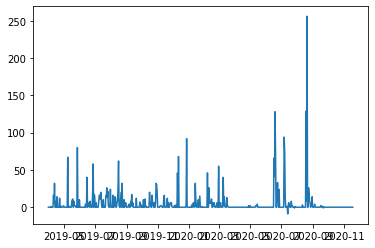

In [ ]:
import matplotlib.pyplot as plt
plt.plot(Fecha_real[0:600],Demanda_real[0:600])
plt.rcParams["figure.figsize"] = (16,4)# 16 4

## Modelo Entorno Real P2-Inventario Optimo Teórico


###  Environment



In [ ]:
import numpy as np
from scipy.optimize import minimize 
ROWS = 5
COLS =Cantidad_dias
S = (2, 0) # primera posición estado inventario, segunda mes
G = (3,COLS-1)

# ENVIRONMENT-------------------------------------------------------------------
class Cliff: 
    def __init__(self):
        self.end = False
        self.pos = S
        self.board = np.zeros([ROWS, COLS])
        # add cliff marked as -1
        self.board[ROWS-1, 0:COLS] = 4 # Excedió Inventario
        self.board[3, 0:COLS] = 3 # Zona Verde
        self.board[2, 0:COLS] = 2 # Zona Amarilla
        self.board[1, 0:COLS] = 1 # Zona Roja 
        self.board[0, 0:COLS] = 0 # Sin inventario
        self.ADU=[]
        self.DLT=[]
        self.LTF=[]
        self.BZR=[]
        self.FV=[]
        self.TOR=[]
        self.TOY=[]
        self.TOG=[]
        self.Zona=0
        self.NFE=Inventario_Inicial
        self.On_hand=Inventario_Inicial
        self.On_hand_teorico=Inventario_Inicial
        self.NFE_teorico=Inventario_Inicial
        self.Inventario_optimo=[]
        self.Inventario_real=[]
        self.action=[]
        self.accion_teorica=0
        self.Supply_order=[0]*(Lead_time+2)
        self.Supply_order_teorico=[0]*(Lead_time+2)
        self.demanda_spike=[]
        self.demanda_spike_horizon=Demanda[1:Order_Spike_Horizon+1]
       
        # Ciclo creado para generar simulación de variables
        for i in range(0, Cantidad_dias):
          #self.ADU.append(ADU)
          self.DLT.append(DLT)
          self.LTF.append(0.5)
          self.FV.append(0.5)
        self.ADU=ADU
        # A continuación se realiza el cálculo de cada zona
        for num1, num2, num3 in zip(self.ADU, self.DLT, self.LTF):
          self.BZR.append(num1 * num2 * num3) #Base Zona Roja
        for num1, num2 in zip(self.BZR, self.FV):
          self.TOR.append((num1 * num2)+num1 ) # Tope superior Zona Roja
        for num1, num2,num3 in zip(self.TOR, self.ADU, self.DLT):
          self.TOY.append(num1 + (num2 * num3) ) # Tope superior Zona Amarilla
        for num1, num2 in zip(self.TOY, self.BZR):
          self.TOG.append(num1 + num2)
        for num1, num2, num3 in zip(self.TOR,self.TOG,self.TOY):
          #self.Inventario_optimo.append((num1+(num2-num3)/2))
          self.Inventario_optimo.append((num1+(num2-num3+num3-num1)/2))
        
    def nxtPosition(self, action):
        #Calculo de la nueva Demanda Spike
        self.demanda_spike=0
        for i in self.demanda_spike_horizon:
          if i >= Order_Spike_Threshold[self.pos[1]]:
            self.demanda_spike+=i
        self.demanda_spike_horizon=Demanda[self.pos[1]+2:self.pos[1]+Order_Spike_Horizon+2] #Demanda con info de los próxinmos periodos del OSH (Order Spike Horizon)
        
        # Calculo de acción teórica según DDMRP--------------------------------
        #print('NFE teorico final',self.NFE_teorico)
        #print('self.nfe teorico',self.NFE_teorico,'<=',self.TOY[self.pos[1]])
        if self.NFE_teorico <= self.TOY[self.pos[1]]: # Si es menor que TOY se genera solicitud de orden    
            if round((self.TOG[self.pos[1]]-self.NFE_teorico)/Increm_QT_Acciones)*Increm_QT_Acciones<MOQ: # Lo mínimo que debo pedir es
              self.accion_teorica=MOQ
              #print('accion teorica MOQ',self.accion_teorica)
            else:
              self.accion_teorica=abs(round((self.TOG[self.pos[1]]-self.NFE_teorico)/Increm_QT_Acciones)*Increm_QT_Acciones) 
              #print('accion teorica Normal',self.accion_teorica) 
        else:
          self.accion_teorica=0
        self.Supply_order_teorico[Lead_time] += self.accion_teorica
        self.On_hand_teorico += self.Supply_order_teorico[0]-Demanda[self.pos[1]]
        self.NFE_teorico = self.On_hand_teorico + sum(self.Supply_order_teorico[1:])-self.demanda_spike
        #print('demanda spike',self.demanda_spike)
        #print('Supply order antes',self.Supply_order_teorico) 
        for i in range(0,Lead_time+1):
          self.Supply_order_teorico[i]=self.Supply_order_teorico[i+1]
        #print('Supply order desp',self.Supply_order_teorico)  
        #print('Accion teórica',self.accion_teorica)    
        #----------------------------------------------------------------

        self.action=action
        self.Supply_order[Lead_time] += action
        self.On_hand += self.Supply_order[0]-Demanda[self.pos[1]]
        self.NFE = self.On_hand + sum(self.Supply_order[1:])-self.demanda_spike
        Periodo= self.pos[1]+1
        # print("+  Sum Supply order",sum(self.Supply_order),"|",self.Supply_order)
        # print("- Demanda Periodo",Demanda[self.pos[1]])
        # print("- Demanda Spike",self.demanda_spike)
        # print("NFE Final",self.NFE,"Periodo",Periodo)
        # print("Spike que esta llegando a accion",self.demanda_spike)

        # Calculo de Nuevo Supply_Order
        for i in range(0,Lead_time+1):
          self.Supply_order[i]=self.Supply_order[i+1]
          
        #Calculo del nivel
        if self.NFE>self.TOG[self.pos[1]]:
          self.Zona=4 #Limite superior ****
        if self.NFE<0:
          self.Zona=0 #Limite inferior ****
        if self.NFE>self.TOR[self.pos[1]] and self.NFE<=self.TOY[self.pos[1]]:
          self.Zona=2 #Zona amarilla
        if self.NFE>=0 and self.NFE<=self.TOR[self.pos[1]]:
          self.Zona=1 #Zona Roja
        if self.NFE>self.TOY[self.pos[1]] and self.NFE<=self.TOG[self.pos[1]]:
          self.Zona=3 #Zona Verde

        nxtPos= (self.Zona,Periodo) 
        # Validación de posición
        if nxtPos[0] >= 0 and nxtPos[0] <= ROWS-1:
            if nxtPos[1] >= 0 and nxtPos[1] <= COLS-1: 
                self.pos = nxtPos
        if nxtPos[1]>=COLS:
            self.end=True
            #print("Ronda Finalizada. Completó Episodio---------------------------------------------")
        if self.NFE>=NFE_Max:
            self.end=True
            #print("Ronda Finalizada. Excedió Inventario Máximo---------------------------------------")
        if self.NFE<=-NFE_Max:
            self.end=True    
            #print("Ronda Finalizada. Excedió Inventario Mínimo---------------------------------------")      
        return self.pos

    def giveReward1(self):
       if self.pos[0] == 3: #Zona verde
           return -10
       if self.pos[0] == 2: #Zona amarilla
           return 20
       if self.pos[0] == 1: #Zona roja
           return -20
       return -100

    def giveReward2(self): 
       if self.NFE-round(self.Inventario_optimo[self.pos[1]])==0:
           return 1000   
       if self.NFE-self.Inventario_optimo[self.pos[1]]!=0:
           return (1/abs(self.NFE-round(self.Inventario_optimo[self.pos[1]])))*1000
       return -1000
        
    def giveReward3(self):
        if self.pos[0] == 3: #Zona verde
            return (-10 - abs(self.On_hand-round(self.Inventario_optimo[self.pos[1]])))
        if self.pos[0] == 2: #Zona amarilla
            return (20 - abs(self.On_hand-round(self.Inventario_optimo[self.pos[1]])))
        if self.pos[0] == 1: #Zona roja
            return (-20 - abs(self.On_hand-round(self.Inventario_optimo[self.pos[1]])))
        return -100   

### Agente Base

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm 
class Agent:  
    def __init__(self, exp_rate=0.1, lr=0.1, sarsa=False, gamma=0.999):
        self.cliff = Cliff()
        self.actions = list(range(0,Increm_QT_Acciones*130,Increm_QT_Acciones))
        self.states = []  # record position and action of each episode
        self.pos = S
        self.exp_rate = exp_rate
        self.lr = lr
        self.gamma= gamma
        self.sarsa = sarsa
        self.Q_values = {}
        self.a=1        
        #self.Q_values=Q_values # Habilitar para cargar Q_values
        #Creacion de Diccionario con Q values
        for i in range(-round(NFE_Max/Increm_QT_NFE)*Increm_QT_NFE,round(NFE_Max/Increm_QT_NFE*1.2)*Increm_QT_NFE,Increm_QT_NFE): 
          for j in range(0,round(max(self.cliff.Inventario_optimo)/10*1.2)*10,10): 
            self.Q_values[(i,j,Lead_time)] = {}
            for a in self.actions:
              self.Q_values[(i,j,Lead_time)][a] = 0
        print(self.Q_values)                                      
#Acción------------------------------------------------------------------------- 
    def chooseAction(self):
        # epsilon-greedy
        mx_nxt_reward =-999
        action = 0
        Demanda_max=max((Demanda[self.pos[1]:self.pos[1]+Lead_time+1]))
        self.actions = list(range(0,round(Demanda_max/Increm_QT_Acciones)*Increm_QT_Acciones+Increm_QT_Acciones*4,Increm_QT_Acciones))        
        if self.cliff.NFE<=(-self.cliff.TOG[self.pos[1]]):
            self.actions = list(range(0,round(abs(self.cliff.NFE+self.cliff.Inventario_optimo[self.pos[1]])/Increm_QT_Acciones)*Increm_QT_Acciones+Increm_QT_Acciones,Increm_QT_Acciones))        
            #print('acciones posibles',self.actions,'NFE',self.cliff.NFE,'Inv Opt',self.cliff.Inventario_optimo[self.pos[1]])
        #print('primer termino',0,'segundo termino',round(Demanda_promedio/10)+Increm_QT_Acciones,'tercer termino',Increm_QT_Acciones+1)    
        if self.cliff.NFE<=self.cliff.TOG[self.pos[1]]:
          if np.random.uniform(0, 1) <= self.exp_rate:
              action = np.random.choice(self.actions)
          else:
            # greedy action
             for a in self.actions:
                  current_position = (round(self.cliff.NFE/Increm_QT_NFE)*Increm_QT_NFE,round(self.cliff.Inventario_optimo[self.pos[1]]/10)*10,round(Lead_time_real[self.pos[1]]))
                  # if all actions have same value, then select randomly   round(max(self.cliff.Inventario_optimo)*1.2/10)*10
                  if len(set(self.Q_values[current_position].values())) == 1:
                    action = np.random.choice(self.actions)
                  else:
                    for a in self.actions:
                      #Itera cada accion en los Q values de la pos actual para identificar cuál es el de mayor valor
                      nxt_reward = self.Q_values[current_position][a]
                      if nxt_reward >= mx_nxt_reward:
                        action = a
                        mx_nxt_reward = nxt_reward
        return action

    def reset(self):
        self.states = []
        self.cliff = Cliff()
        self.pos = S
        #positions=[(2,0,150)]    

#Ejecutador estimación q values-------------------------------------------------       
    def play(self, rounds=100,Modelo_Rewards=1): 
        self.episodios=[]
        self.acum_rewards_mean=[]
        self.Inventario_opt=[]
        self.Periodo_real=[]
        self.rewards_hist=[]
        self.sum_rewards_hist=[]
        Modelo_de_Rewards=Modelo_Rewards
        #actions=[]
  
        for i in tqdm(range(rounds)):
            acum_rewards=[]
            while 1:
                #print("NFE Inicial:{} Recepcion orden:{}|Demanda Periodo:{} Spike Hor:{}|Acción:{}|Ordenes pedido:{}|TOR {} TOY {} TOG {}  ".format(self.cliff.NFE,self.cliff.Supply_order[0],Demanda[self.pos[1]],self.cliff.demanda_spike_horizon,action,self.cliff.Supply_order,self.cliff.TOR[self.pos[1]],self.cliff.TOY[self.pos[1]],self.cliff.TOG[self.pos[1]]))
                # Estado actual
                state = (round(self.cliff.NFE/Increm_QT_NFE)*Increm_QT_NFE,round(self.cliff.Inventario_optimo[self.pos[1]]/10)*10,round(Lead_time_real[self.pos[1]]))
                #Tomo una acción
                action = self.chooseAction()
                # Actualizo posición
                self.cliff.pos = self.cliff.nxtPosition(action)
                self.pos = self.cliff.pos 
                next_state = (round(self.cliff.NFE/Increm_QT_NFE)*Increm_QT_NFE,round(self.cliff.Inventario_optimo[self.pos[1]]/10)*10,round(Lead_time_real[self.pos[1]]))
                # Rewards de la acción
                if Modelo_Rewards==1:
                  reward=self.cliff.giveReward1()
                elif Modelo_Rewards==2:
                  reward=self.cliff.giveReward2()
                else:
                  reward=self.cliff.giveReward3() 
                #Update Q values
                td_target=reward+self.gamma*(np.max(list(self.Q_values[next_state])))
                #print('next state',next_state)
                td_error=td_target-self.Q_values[state][action]
                #print('STATE',state,'action',action)
                self.Q_values[state][action] += self.lr*td_error            
                acum_rewards.append(reward)#son los rewards del episodio
                #print('ronda',i)
                #print("NFE Final {} | Ordenes pedido {} |Rewards {}".format(self.cliff.NFE,self.cliff.Supply_order,self.cliff.giveReward()))
                if self.cliff.end:
                    break
            self.rewards_hist.append(np.mean(acum_rewards)) #almacenando la media de cada episodio
            self.episodios.append(i)
            self.acum_rewards_mean.append(statistics.median(self.rewards_hist)) #almacenando la media acumulada de cada episodio
            self.sum_rewards_hist.append(sum(acum_rewards))
            pass
            self.reset() 

### Aprendizaje

In [ ]:
rounds=300
Modelo_de_Rewards=3
ag = Agent(exp_rate=0.05, lr=0.1, sarsa=False,gamma=0.9999)
ag.play(rounds,Modelo_Rewards=Modelo_de_Rewards)

  0%|          | 0/300 [00:00<?, ?it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 300/300 [01:26<00:00,  3.47it/s]


### Metricas de Evalución Aprendizaje

#### Resultados y Visualización Convergencia ¡!

In [ ]:
# 1 Metricas de entrenamiento
episodes=list(range(rounds))
PBAR=[0]
AAR_hist=[]
acum_rewards_mean_n = minmax_scale(ag.acum_rewards_mean)
# 1.1 AAR Media Aritmetica acumulada. se cogen todos los rewards de cada episodio y se le calcula la media
acum_rewards_Q=ag.acum_rewards_mean
AR=ag.sum_rewards_hist # los históricos de la sumataria de cada episodio
AR_norm = minmax_scale(AR) #AR normalizado
AAR_hist= [round(num, 2) for num in acum_rewards_mean_n]
# 1.2 PBAR
BAR=round(max(AR_norm),2) #Máximo
for i in range(1,len(AAR_hist)):
  PBAR.append(round(max(AR_norm[0:i])/BAR,2))

# Resultados
table = [['Episodio', 'AAR', 'PBAR'],
         ['100',AAR_hist[100-1], PBAR[100-1]],
         ['200',AAR_hist[200-1], PBAR[200-1]],
         #['500',AAR_hist[500-1], PBAR[500-1]],
         #['1000',AAR_hist[1000-1], PBAR[1000-1]],
         #['2000',AAR_hist[2000-1], PBAR[2000-1]],
         #['5000',AAR_hist[5000-1], PBAR[5000-1]],
         #['10000',AAR_hist[10000-1], PBAR[10000-1]],
         #['20000',AAR_hist[20000-1], PBAR[20000-1]],
         #['30000',AAR_hist[30000-1], PBAR[30000-1]]
         ]
print(tabulate(table))

#Guardar resultados Convergencia y Q_values
P2_Convergencia_Inv_Opt_DDMRP=acum_rewards_mean_n
pickle.dump(P2_Convergencia_Inv_Opt_DDMRP, open("P2R2_Convergencia_Inv_Opt_DDMRP.pkl", "wb"))
pickle.dump(ag.Q_values, open("Q_values_P2R2_Inv_Opt_DDMRP.pkl", "wb"))
pickle.dump(AAR_hist, open("P2R2_entrena_AAR_Inv_Opt_DDMRP.pkl", "wb"))
pickle.dump(PBAR, open("P2R2_entrena_PBAR_Inv_Opt_DDMRP.pkl", "wb"))

--------  ----  ----
Episodio  AAR   PBAR
100       0.23  1.0
200       0.1   1.0
--------  ----  ----


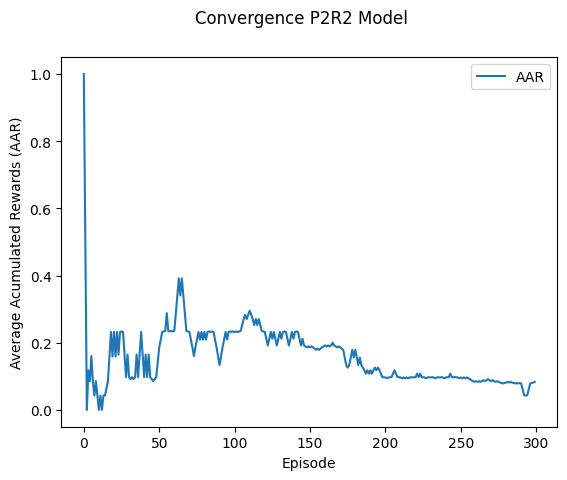

In [ ]:
# Plot Convergencia
plt.rcParams.update(plt.rcParamsDefault)
plt.plot(ag.episodios,acum_rewards_mean_n, label = "AAR")
plt.suptitle('Convergence P2R2 Model')
plt.xlabel("Episode")
plt.ylabel("Average Acumulated Rewards (AAR)")
plt.legend(loc=0)

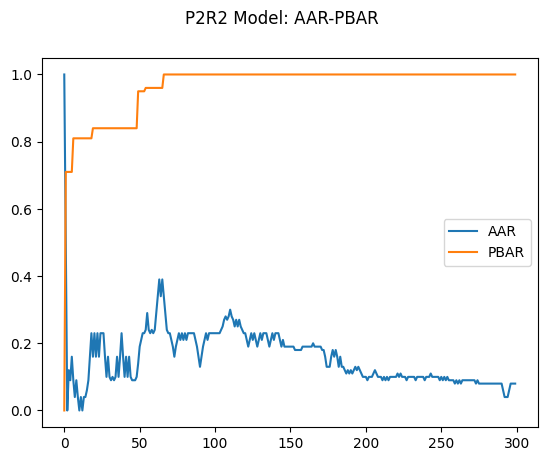

In [ ]:
# Plot AAR-PBAR
plt.suptitle('P2R2 Model: AAR-PBAR')
plt.plot(episodes,AAR_hist,label="AAR")
plt.plot(episodes,PBAR, label="PBAR")
plt.legend(loc=0)

### Test

In [ ]:
#Demanda real del escenario
Dias_Test=365
Inicio_Visualiz=0
Demanda_real = Data['Demand'].values.astype(int).tolist() #Original
Demanda_real=Demanda_real[Inicio_Visualiz:Dias_Test]
Meses=Data['Fecha'].tolist()
Meses=Meses[Inicio_Visualiz:Dias_Test]
Cantidad_dias=Dias_Test
COLS =Cantidad_dias
Demanda=Demanda_real
ADU = ADU_real
Order_Spike_Threshold=ADU
# Q-learning
ag_op = Agent(exp_rate=0,lr=0,sarsa=False)
ag_op.Q_values = ag.Q_values #son los Q valores calculados en el play anterior revisar, estaba formulado
states = []
NFE=[]
Demand=[]
Periodo=[]
Inv_Opt=[]
NFE_Teorico=[]
accion_teorica=[]
rewards_hist_test=[]
acciones_base=[]
while 1: #Loop infinito
    curr_state = ag_op.pos # trayendo posicion actual
    #print("---------DIA",ag_op.pos[1],"---------")
    action = ag_op.chooseAction()#Actua con respecto Q values
    acciones_base.append(action)
    states.append(curr_state)
    NFE.append(ag_op.cliff.On_hand)
    NFE_Teorico.append(ag_op.cliff.On_hand_teorico)
    #print("on hand",ag_op.cliff.On_hand,"NFE",ag_op.cliff.NFE)
    Demand.append(Demanda[ag_op.pos[1]])
    Inv_Opt.append(ag_op.cliff.Inventario_optimo[ag_op.pos[1]])
    Periodo.append(curr_state[1])
    # print("Inicial:Pos:{}|NFE:{} Recepcion orden:{}|Demanda Periodo:{} Spike Hor:{}|Acción:{}|Ordenes pedido:{}|TOR {} TOY {} TOG {} Inv Opt Level {}  ".format
    #       (curr_state,NFE[ag_op.pos[1]],ag_op.cliff.Supply_order[0],Demand[ag_op.pos[1]],ag_op.cliff.demanda_spike_horizon,
    #        action,ag_op.cliff.Supply_order, ag_op.cliff.TOR[ag_op.pos[1]],ag_op.cliff.TOY[ag_op.pos[1]],
    #        ag_op.cliff.TOG[ag_op.pos[1]],ag_op.cliff.Inventario_optimo[ag_op.pos[1]]))   
    #print(ag_op.tiempo)
    # next position
    ag_op.cliff.pos = ag_op.cliff.nxtPosition(action)
    ag_op.pos = ag_op.cliff.pos
    # print("Posicion Final {} | NFE {} | Ordenes pedido {} |Rewards {}".format(
    #     ag_op.pos,ag_op.cliff.NFE,ag_op.cliff.Supply_order,ag_op.cliff.giveReward()))
    if Modelo_de_Rewards==1:
      rewards_hist_test.append(ag_op.cliff.giveReward1())
    elif Modelo_de_Rewards==2:
      rewards_hist_test.append(ag_op.cliff.giveReward2())
    else:
      rewards_hist_test.append(ag_op.cliff.giveReward3())
    accion_teorica.append(ag_op.cliff.accion_teorica)
    if ag_op.cliff.end:
        break

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



#### Visualización Result

-------Inventario Simulación--------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
  # This is added back by InteractiveShellApp.init_path()


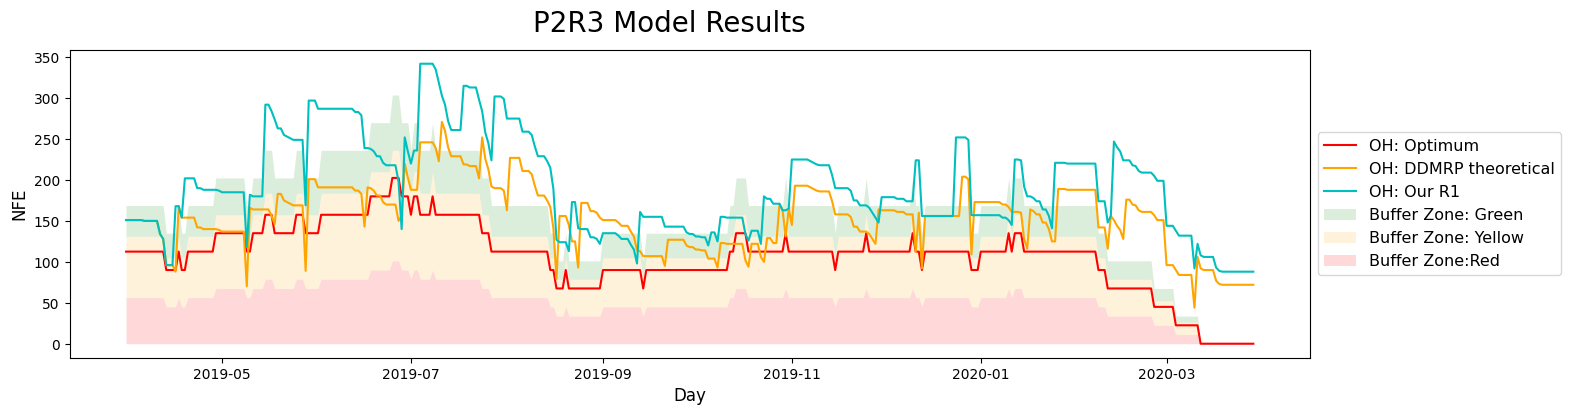

In [ ]:
# Visualización Resultado Test
Dias_Visualiz=Dias_Test
Inicio_Visualiz=0
print("-------Inventario Simulación--------")
#plt.plot(Data['Fecha'][Inicio_Visualiz:Dias_Visualiz],Demanda[Inicio_Visualiz:Dias_Visualiz],'k', label='Demanda') 
plt.plot(Data['Fecha'][Inicio_Visualiz:Dias_Visualiz], Inv_Opt[Inicio_Visualiz:Dias_Visualiz], label = "OH: Optimum",color='red') 
plt.plot(Data['Fecha'][Inicio_Visualiz:Dias_Visualiz], NFE_Teorico[Inicio_Visualiz:Dias_Visualiz], label = "OH: DDMRP theoretical",color='orange')
plt.plot(Data['Fecha'][Inicio_Visualiz:Dias_Visualiz], NFE[Inicio_Visualiz:Dias_Visualiz], 'c',label = "OH: Our R1")   
plt.suptitle('P2'+'R'+str(Modelo_de_Rewards)+' Model Results', fontsize=20)
plt.fill_between(Data['Fecha'][Inicio_Visualiz:Dias_Visualiz], Cliff().TOG[Inicio_Visualiz:Dias_Visualiz], Cliff().TOY[0:Dias_Visualiz], where=(Cliff().TOG > Cliff().TOY), color='green', alpha=0.14,interpolate=True,linewidth=0.0,label='Buffer Zone: Green')
plt.fill_between(Data['Fecha'][Inicio_Visualiz:Dias_Visualiz], Cliff().TOY[Inicio_Visualiz:Dias_Visualiz], Cliff().TOR[0:Dias_Visualiz], where=(Cliff().TOY > Cliff().TOR), color='orange', alpha=0.14,interpolate=True,linewidth=0.0,label='Buffer Zone: Yellow')
plt.fill_between(Data['Fecha'][Inicio_Visualiz:Dias_Visualiz], Cliff().TOR[Inicio_Visualiz:Dias_Visualiz], [0]*Dias_Visualiz, color='red', alpha=0.15,interpolate=True,linewidth=0.0,label='Buffer Zone:Red')
plt.xlabel('Day', fontsize=12)
plt.ylabel('NFE', fontsize=12)
plt.rcParams["figure.figsize"] = (16,4)
plt.legend(prop={'size': 11.5},loc='center left', bbox_to_anchor=(1.0, 0.5))
#plt.savefig('myfigure_200.png', dpi=200)
plt.show() 

#### Metricas de Evalución Resultados

In [ ]:
Dist=[]
Rompimiento=0
Rompimiento_Teo=0
# Resultados del Modelo
# 2. Logistica Rompimiento Inventario
# 2.1 Rompimiento 
for i in NFE:
  if i < 0:
    Rompimiento +=1

for i in NFE_Teorico:
  if i < 0:
    Rompimiento_Teo +=1
# 2.2 Logistica REL
REL= round(variance(acciones_base)/variance(Demanda_real),2)
REL_Teo = round(variance(accion_teorica)/variance(Demanda_real),2)
# 2.3 Dist a Inv Optimo
for num1, num2 in zip(NFE, Inv_Opt):
  Dist.append(abs(num1 - num2)) #Base Zona Roja
Dist_inv_Opt=statistics.median(Dist)
for num1, num2 in zip(NFE_Teorico, Inv_Opt):
  Dist.append(abs(num1 - num2)) #Base Zona Roja
Dist_inv_Opt_Teo=statistics.median(Dist)

# 3. Funcionamiento RL 
# 3.1 ARR
AR_norm_test = minmax_scale(rewards_hist_test)
ARR_test=round(mean(AR_norm_test),2)

#Guardar resultados Convergencia
pickle.dump(Rompimiento, open("P2R2_Rompimiento_Inv_Opt_DDMRP.pkl", "wb"))
pickle.dump(Rompimiento_Teo, open("P2R2_Rompimiento_Teo_Inv_Opt_DDMRP.pkl", "wb"))
pickle.dump(REL, open("P2R2_REL_Inv_Opt_DDMRP.pkl", "wb"))
pickle.dump(REL_Teo, open("P2R2_REL_Teo_Inv_Opt_DDMRP.pkl", "wb"))
pickle.dump(Dist_inv_Opt, open("P2R2_Dist_inv_Opt_Inv_Opt_DDMRP.pkl", "wb"))
pickle.dump(Dist_inv_Opt_Teo, open("P2R2_Dist_inv_Opt_Teo_Inv_Opt_DDMRP.pkl", "wb"))
pickle.dump(ARR_test, open("P2R2_ARR_Inv_Opt_DDMRP.pkl", "wb"))

# Gráficos Finales


In [ ]:
#3. Resultados Tabla
#3.1 Resultados P2R2
#3.2 Resultados P2R2
#3.3 Resultados P2R2
P2R2_ARR_Inv_Opt_DDMRP=pickle.load(open("P2R2_ARR_Inv_Opt_DDMRP.pkl", "rb"))
P2R2_Dist_inv_Opt_Inv_Opt_DDMRP=pickle.load(open("P2R2_Dist_inv_Opt_Inv_Opt_DDMRP.pkl", "rb"))
P2R2_Rompimiento_Inv_Opt_DDMRP=pickle.load(open("P2R2_Rompimiento_Inv_Opt_DDMRP.pkl", "rb"))
P2R2_REL_Inv_Opt_DDMRP=pickle.load(open("P2R2_REL_Inv_Opt_DDMRP.pkl", "rb"))
#3.4 Resultados P2R2 Teorico
P2R2_Dist_inv_Opt_Teo_Inv_Opt_DDMRP=pickle.load(open("P2R2_Dist_inv_Opt_Teo_Inv_Opt_DDMRP.pkl", "rb"))
P2R2_REL_Teo_Inv_Opt_DDMRP=pickle.load(open("P2R2_REL_Teo_Inv_Opt_DDMRP.pkl", "rb"))
P2R2_Rompimiento_Teo_Inv_Opt_DDMRP=pickle.load(open("P2R2_Rompimiento_Teo_Inv_Opt_DDMRP.pkl", "rb"))

tableA = [['Case S', 'AAR', 'Dist OH*','Rompimiento','REL'],
         ['P2R2',],
         ['P2R2',],  
         ['P2R2',P2R2_ARR_Inv_Opt_DDMRP,P2R2_Dist_inv_Opt_Inv_Opt_DDMRP,P2R2_Rompimiento_Inv_Opt_DDMRP,P2R2_REL_Inv_Opt_DDMRP],
         ['Teorico','N/A',P2R2_Dist_inv_Opt_Teo_Inv_Opt_DDMRP,P2R2_Rompimiento_Teo_Inv_Opt_DDMRP,P2R2_REL_Teo_Inv_Opt_DDMRP]
         ]
print(tabulate(tableA))

-------  ----  --------  -----------  ----
Case S   AAR   Dist OH*  Rompimiento  REL
P2R2
P2R2
P2R2     0.34  31.5      1            1.96
Teorico  N/A   31.75     1            1.34
-------  ----  --------  -----------  ----


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!wget ""